<a href="https://colab.research.google.com/github/arnisafazla/Neural_Networks_Implementations/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from numpy.random import seed
from numpy.random import randn
from numpy import linspace

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = h5py.File("/content/drive/MyDrive/EEE443/hw2/assign2_data1.h5", "r")
trainims = np.array(file['trainims'])
testims = np.array(file['testims'])
trainlbls = np.array(file['trainlbls']) - 1
testlbls = np.array(file['testlbls']) - 1
print(trainims.shape, testims.shape, trainlbls.shape, testlbls.shape)
X_train = trainims.reshape((trainims.shape[0], -1))
Y_train = trainlbls
X_test = testims.reshape((testims.shape[0], -1))
Y_test = testlbls
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
classes = np.unique(testlbls)
no_of_classes = classes.shape[0]
classes

array([-1.,  0.])

Text(0.5, 1.0, '0.0')

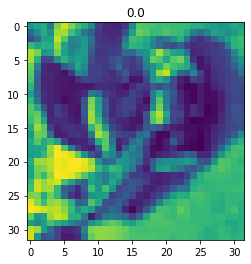

In [ ]:
plt.imshow(trainims[-1])
plt.title(trainlbls[-1])

In [ ]:
# mean squared error - run for train and test data.
def MSE(y, d):
  y = y.reshape((-1, 1))
  d = d.reshape((-1, 1))
  n = y.shape[0]
  d = d + 1
  y = (y + 1) / 2
  # y is output of the network, n x 1 vector with range -1 to 1. 
  # d is n x 1 vector with range -1 or 0.
  return np.sum((d - y) ** 2) / n

# mean error - used in backpropagation of the output layer
def error(y, d):
  y = y.reshape((-1, 1))
  d = d.reshape((-1, 1))
  d = d + 1
  y = (y + 1) / 2
  # y is output of the network, n x 1 vector with range -1 to 1. 
  # d is n x 1 vector with range -1 or 0.
  return d - y

# mean classification error
def MCE(y, d):
  y = y.reshape((-1, 1))
  d = d.reshape((-1, 1))
  n = y.shape[0]
  d = d + 1
  y = np.maximum(0,np.ceil(y))
  # y is output of the network, 2 x 1 vector with range -1 to 1. 
  # d is -1 or 0.
  # percentage of wrongly classified samples
  return np.sum(np.abs(d - y)) / n

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1.0 - np.tanh(x)**2

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
# matplotlib.use('cairo')

# plot all the error curves
def draw_error_curves(error, pdf=None):
  x = linspace(0, 1, len(error[0]))
  ax = plt.subplot(111)

  MSE_train = error[0]
  MCE_train = error[1]
  MSE_test = error[2] 
  MCE_test = error[3]

  plt.plot(x, MSE_train, label = "MSE_train")
  plt.plot(x, MSE_test, label = "MSE_test")

  plt.xlabel("epoch")
  plt.ylabel("Error metrics")
  plt.title("MSE")
  ax.legend()
  if pdf != None:
    plt.savefig(fig1)
  else:
    plt.show()

  plt.cla()

  x = linspace(0, 1, len(error[2]))
  ax = plt.subplot(111)
  plt.plot(x, MCE_train, label = "MCE_train")
  plt.plot(x, MCE_test, label = "MCE_test")
  plt.xlabel("epoch")
  plt.ylabel("Error metrics")
  plt.title("MCE")
  ax.legend()
  if pdf != None:
    plt.savefig(fig2)
  else:
    plt.show()

In [ ]:

"""
year = linspace(0, 1, 6) 
tutorial_count = [39, 117, 111, 110, 67, 29]
tutorial2 = [10, 20, 30, 40, 50, 60]
ax = plt.subplot(111)
plt.figure(200)
plt.plot(year, tutorial_count, color="#6c3376", linewidth=3)  
plt.plot(year, tutorial2, color="red", linewidth=3)  
plt.xlabel('Year')  
plt.ylabel('Number of futurestud.io Tutorials')  
plt.title('hi')
ax.legend()
"""
with PdfPages('line_plot.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    # pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    # plt.rc('text', usetex=False)
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [ ]:
class Layer (object):
  def __init__(self, no_of_units, input_shape, init_std, learning_rate, alpha):
    # W is extended version
    self.no_of_units = no_of_units
    self.W = np.random.normal(0, init_std, no_of_units * (input_shape + 1)).reshape((no_of_units, input_shape + 1))
    # W has b as well
    self.learning_rate = learning_rate
    self.alpha = alpha
    self.update = np.zeros(self.W.shape)
    self.r = np.zeros(self.W.shape)
    return
    # alpha and r for RMSProp optimization.

  def forward_pass(self, X):
    # print('in forward pass')
    # print("x: ", X.shape)
    X_e = np.array([np.append(row, -1) for row in X])
    # print("X_e, self.W.T: ")
    # print(X_e.shape, self.W.T.shape)
    v = np.matmul(X_e, self.W.T)
    # save for backpropagation
    self.X = X_e
    self.v = v
    # print("tanh(v): ")
    # print(tanh(v).shape)
    return tanh(v)
  def back_propogate(self, error, batch_size):
    # print("error: ", error)
    delta = np.array([error[i] * tanh_derivative(self.v[i]) for i in range(self.v.shape[0])])
    # print("delta: ", delta)
    # print("X: ", self.X)
    gradient = np.matmul(delta.T, self.X)
    self.r = self.alpha * self.r + (1 - self.alpha) * gradient ** 2
    gradient_sum = np.sum(np.abs(gradient))
    # print("     W: ", self.W.shape)
    # print("gradient: ", self.gradient)
    self.W_update = self.learning_rate * gradient / (0.0000000000000001 + np.sqrt(self.r))
    self.W_update = self.W_update / batch_size  # take average of the W updates
    # print("W_update: ", self.W_update)
    W_raw = self.W.T[0:self.W.shape[-1] - 1].T
    self.W = self.W + self.W_update 
    # print("     W_raw: ", W_raw.shape)
    # print("     delta: ", delta.shape)
    next_error = np.matmul(delta, W_raw)
    return next_error, gradient_sum

In [ ]:
class Model(object):
  def __init__(self, layers, units, input_shape, init_std, learning_rate, alpha):
    self.layers = []
    self.layers.append(Layer(units[0], input_shape=input_shape, init_std=init_std, learning_rate=learning_rate, alpha=alpha))
    for i in range(layers-1):
      self.layers.append(Layer(units[i+1], input_shape=units[i], init_std=init_std, learning_rate=learning_rate, alpha=alpha))
    self.no_of_layers = layers
    self.input_shape = input_shape

  def train(self, X_train, Y_train, X_test, Y_test, batch_size, max_epochs, verbose=0):
    MSE_train_hist = []
    MCE_train_hist = []
    MSE_test_hist = []
    MCE_test_hist = []

    n = X_train.shape[0]
    no_of_batches = n // batch_size
    extra = n % batch_size

    # shuffle X_test, Y_Test once
    index = [*range(Y_test.shape[0])]
    random.shuffle(index)
    X_test_shuffled = np.array([X_test[i] for i in index])
    Y_test_shuffled = np.array([Y_test[i] for i in index])

    for epoch in range(max_epochs):   # ??
      # for loop to see the smallest error
      gradient = 0
      MSE_train = 0
      MCE_train = 0

      # shuffle X_train, Y_train
      index = [*range(n)]
      random.shuffle(index)
      X_shuffled = np.array([X_train[i] for i in index])
      Y_shuffled = np.array([Y_train[i] for i in index])

      for i in range(no_of_batches):
        if i < no_of_batches - 1:
          net_batch_size = batch_size
          batch_X = X_shuffled[i * batch_size:(i+1) * batch_size]
          batch_Y = Y_shuffled[i * batch_size:(i+1) * batch_size]
          
        else:
          net_batch_size = batch_size + extra
          batch_X = X_shuffled[i * batch_size:(i+1) * batch_size + extra]
          batch_Y = Y_shuffled[i * batch_size:(i+1) * batch_size + extra]
          
        for layer in self.layers:
          batch_X = layer.forward_pass(batch_X)
        MSE_train = MSE_train + MSE(batch_X, batch_Y)
        MCE_train = MCE_train + MCE(batch_X, batch_Y)
        # return batch_X, batch_Y
        layer_error = error(batch_X, batch_Y)
        # print("output layer error: ", layer_error)
        for i in range(self.no_of_layers-1, -1, -1):
          # try:
          layer_error, grad = self.layers[i].back_propogate(layer_error, net_batch_size)
          gradient += grad
          #except:
          #  return 
          # print("hidden layer error: ", layer_error)
          # in backpropogate update the Ws and return W.T * delta for the next layer
      MSE_train_hist.append(MSE_train / no_of_batches)
      MCE_train_hist.append(MCE_train / no_of_batches)
      MSE_test, MCE_test = self.test(X_test_shuffled, Y_test_shuffled)
      MSE_test_hist.append(MSE_test)
      MCE_test_hist.append(MCE_test)
      if verbose:
        print("Epoch ", epoch, " => MSE_train: ", MSE_train, ", MCE_train: ", MCE_train, ", MSE_test: ", MSE_test, ", MCE_test: ", MCE_test, " gradient: ", gradient)
    return MSE_train_hist, MCE_train_hist, MSE_test_hist, MCE_test_hist

  def test(self, X, Y):
    X_tmp = X
    for layer in self.layers:
      X_tmp = layer.forward_pass(X_tmp)
      # X_tmp has the output now
    return MSE(X_tmp, Y), MCE(X_tmp, Y)

In [ ]:
# run a test to find the epochs to convergence and error metrics
def test_params(no_of_layers, X_train, Y_train, X_test, Y_test, params, epochs, alpha, verbose=0):
  (N, init_std, mini_batch_size, learning_rate) = params
  # N -> list of no. of units in each layer
  # no need to shuffle X and Y because shuffled inside the init function
  model = Model(no_of_layers, N, X_train.shape[1], init_std=init_std, learning_rate=learning_rate, alpha=alpha)
  MSE_train_hist, MCE_train_hist, MSE_test_hist, MCE_test_hist = model.train(X_train, Y_train, X_test, Y_test, mini_batch_size, epochs, verbose=verbose)
  return (MSE_train_hist, MCE_train_hist, MSE_test_hist, MCE_test_hist)

In [ ]:
print("Part 1.a) One hidden layer. Experiment with different number of neurons N in the hidden layer, ")
print("initialization of weight and bias terms, and mini-batch sample sizes. Select the best set of params and run until convergence.")
print("Print the curves for each error metrics")

Part 1.a) One hidden layer. Experiment with different number of neurons N in the hidden layer, 
initialization of weight and bias terms, and mini-batch sample sizes. Select the best set of params and run until convergence.
Print the curves for each error metrics


In [ ]:
N_test = [5, 10]
init_std_test =[0.01, 0.1, 1]
mini_batches_test = [64, 128, 256]
learning_rate_test = [0.1, 0.5]
i = 0
for N in N_test:
  for batch_size in mini_batches_test:
      for init_std in init_std_test:
        for learning_rate in learning_rate_test:
          i += 1
          if i == 26:
            print([N, init_std, batch_size, learning_rate])

[10, 0.01, 128, 0.5]


In [ ]:
N_test = [10, 30, 50]
init_std_test =[0.01, 0.1, 1]
mini_batches_test = [64, 128, 256]
learning_rate_test = [0.1, 0.5]
params_list = []
converge_list = []
error_list = []

for N in N_test:
  for batch_size in mini_batches_test:
      for init_std in init_std_test:
        for learning_rate in learning_rate_test:
          params = [(N, 1), init_std, batch_size, learning_rate]
          print(params)
          try:
            error_metrics = test_params(2, X_train, Y_train, X_test, Y_test, params, 50, 0)
          except:
            print("Overflow exception")
            continue
          params_list.append(params)
          error_list.append(error_metrics)
          # draw_error_curves(error_metrics)
error_list = np.array(error_list)
MCE_list = np.array([error_metric[3] for error_metric in error_list])
min_MCE_list = np.array([np.min(MCE) for MCE in MCE_list])
# find the parameters combination with smallest MCE_test 
i = np.argmin(min_MCE_list)
params = params_list[i]
error_metrics = error_list[i]
print(params)

In [ ]:
for i in range(len(params_list)):
  print(params_list[i], ": min MCE_test error = ", min_MCE_list[i])

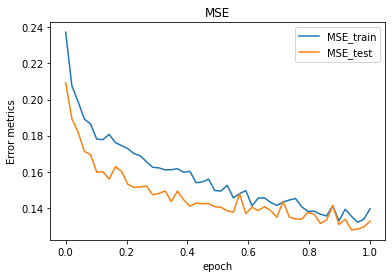

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


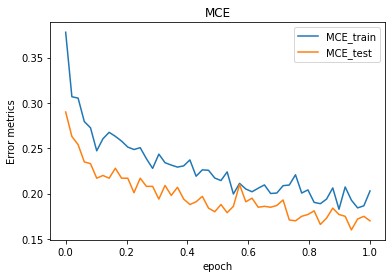

In [ ]:
draw_error_curves(error_metrics[:][0:])

Run the model until convergence with the parameters N = 10 (no. of units in hidden layer), init_std = 0.01 (std of the normal distribution the weights are taken from), batch_size=128 and learning_rate=0.5


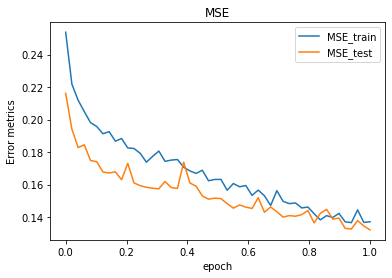

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


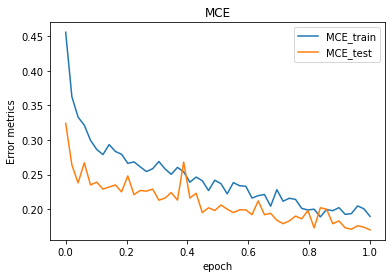

In [ ]:
print('Run the model until convergence with the parameters N = 10 (no. of units in hidden layer), init_std = 0.01 (std of the normal distribution the weights are taken from), batch_size=128 and learning_rate=0.5')
params = [(10, 1), 0.1, 64, 0.1]
epochs = 50
error_metrics = test_params(2, X_train, Y_train, X_test, Y_test, params, epochs, 0, verbose=1)
draw_error_curves(error_metrics[:][0:])

In [ ]:
epochs

50

In [ ]:
print('Part c) try small and large number of hidden neurons.')

params[0] = (5,1) # small no. of N
error_metrics_small = test_params(2, X_train, Y_train, X_test, Y_test, params, epochs, 0, verbose=0)

params[0] = (30,1)  # large no. of N
error_metrics_large = test_params(2, X_train, Y_train, X_test, Y_test, params, epochs, 0, verbose=0)

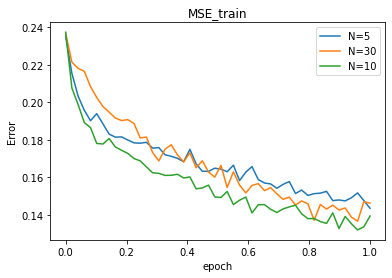

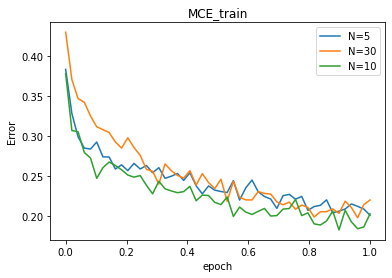

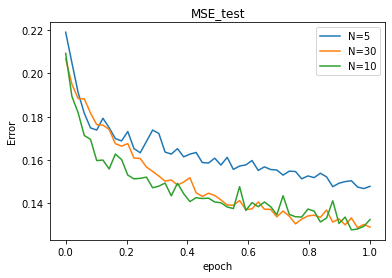

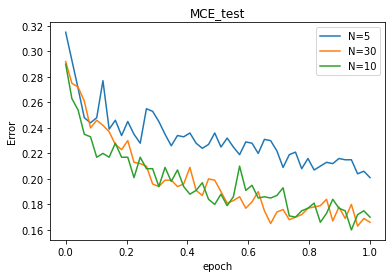

In [ ]:
x = linspace(0, 1, len(error_metrics[0]))
names = ["MSE_train", "MCE_train", "MSE_test", "MCE_test"]

for i in range(4):
  ax = plt.subplot(111)
  plt.plot(x, error_metrics_small[i][:50], label = "N=5")
  plt.plot(x, error_metrics_large[i][:50], label = "N=30")
  plt.plot(x, error_metrics[i], label = "N=10")

  plt.xlabel("epoch")
  plt.ylabel("Error")
  plt.title(names[i])
  ax.legend()
  plt.show()

In [ ]:
print('Part d) Two layered network. find params that work well.')
N1_test = [10, 30, 50]  # first layer
N2_test = [10, 50, 100] # second layer
init_std_test =[0.01, 0.1, 1]
mini_batches_test = [64, 128, 256]
learning_rate_test = [0.1, 0.5]
params_list = []
converge_list = []
error_list = []
min_err_list = []

for N1 in N1_test:
  for N2 in N2_test:
    for batch_size in mini_batches_test:
        for init_std in init_std_test:
          for learning_rate in learning_rate_test:
            params = [(N1, N2, 1), init_std, batch_size, learning_rate]
            print(params)
            try:
              error_metrics = test_params(3, X_train, Y_train, X_test, Y_test, params, 50, 0)
            except:
              print("Overflow exception")
              continue
            params_list.append(params)
            error_list.append(error_metrics)
            # draw_error_curves(error_metrics)
error_list = np.array(error_list)
MCE_list = np.array([error_metric[3] for error_metric in error_list])
min_MCE_list = np.array([np.min(MCE) for MCE in MCE_list])
# find the parameters combination with smallest MCE_test 
i = np.argmin(min_MCE_list)
params = params_list[i]
error_metrics = error_list[i]
print(params)

In [ ]:
for i in range(len(params_list)):
  print(params_list[i], ": min MCE_test error = ", min_MCE_list[i])

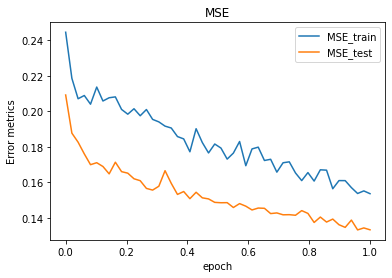

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


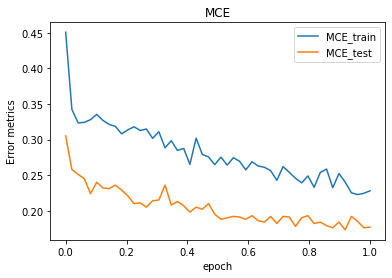

In [ ]:
params = [(50, 100, 1), 0.1, 128, 0.1]
error_metrics = test_params(3, X_train, Y_train, X_test, Y_test, params, 50, 0)
draw_error_curves(error_metrics[:][0:])

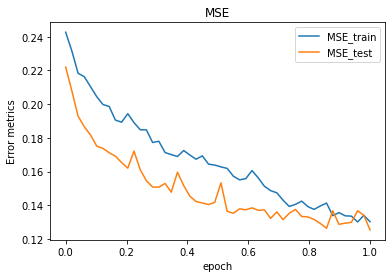

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


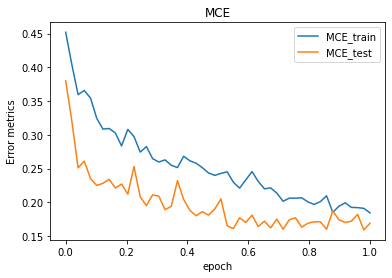

In [ ]:
draw_error_curves(error_metrics[:][0:])

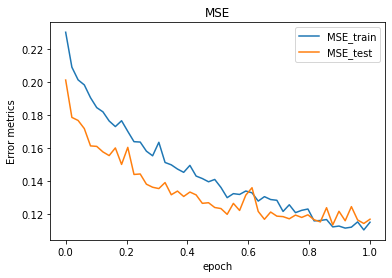

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


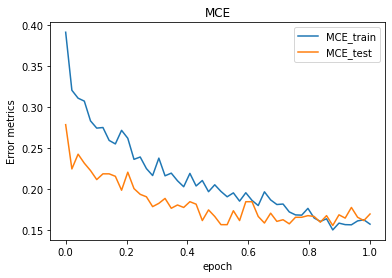

In [ ]:
params = [(50, 10, 1), 0.1, 64, 0.1]
error_metrics = test_params(3, X_train, Y_train, X_test, Y_test, params, 50, 0.1)
draw_error_curves(error_metrics[:][0:])

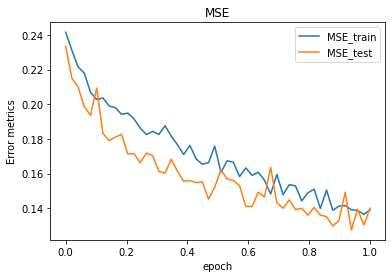

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


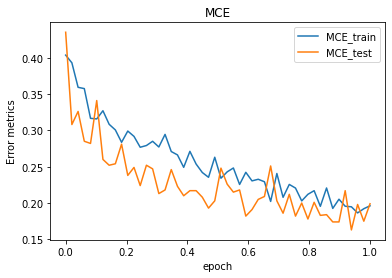

In [ ]:
params = [(50, 10, 1), 0.1, 64, 0.1]
error_metrics = test_params(3, X_train, Y_train, X_test, Y_test, params, 50, 0.5)
draw_error_curves(error_metrics[:][0:])